In [1]:
%matplotlib notebook

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import string
import math


from scipy.spatial import distance
from math import atan2, degrees
import csv

from IPython.display import clear_output
from shapely.geometry import Point, Polygon

In [2]:
PATH_BEGIN = "data/calibration_data_begin/"
PATH_BEGIN_END = "data/calibration_data_begin_end/"

tasks = ['V1_190x120.png', 'V2_950x120.png', 'V3_1710x120.png',
       'V4_190x600.png', 'V5_950x600.png', 'V6_1710x600.png',
       'V7_190x1080.png', 'V8_950x1080.png', 'V9_1710x1080.png',
       'VA_950x600.png', 'VB_950x600.png', 'VC_950x600.png',
       'VD_950x600.png']

In [3]:
dataset = pd.read_csv(PATH_BEGIN + tasks[0][0:len(tasks[0])-4] + ".tsv", low_memory=False, sep="\t")

In [3]:
MONITOR_HEIGHT = 32.4 # Monitor height in cm
MONITOR_VERTICAL_RESOLUTION = 1200 # Vertical resolution of the monitor
MONITOR_HORIZONTAL_RESOLUTION = 1900 # # Horizontal resolution of the monitor


def get_head_distance(distanceleft, distanceright):
    """ get head distance"""
    if np.isnan(distanceleft) and np.isnan(distanceright):
        return -1
    if np.isnan(distanceleft):
        return distanceright / 10
    if np.isnan(distanceright):
        return distanceleft / 10
    return ((distanceleft + distanceright) / 2.0) /10


def get_distances_accuracy(df, accuracy, point_in_image, participant_name):
    """ 
       accuracy calculation  
    """
    for index, row in df.iterrows():
        dist_euc = distance.euclidean(point_in_image, [row["GazePointX (MCSpx)"], row["GazePointY (MCSpx)"]])
        head_distance = get_head_distance(row["DistanceLeft"], row["DistanceRight"])
        if head_distance > 0:
            # Calculate degree per pixel ( tanges of angle ) and then divide it to get degree per pixel from radians
            deg_per_pixel = degrees(atan2(.5 * MONITOR_HEIGHT, head_distance)) / (.5 * MONITOR_VERTICAL_RESOLUTION)
            dist_in_deg = dist_euc * deg_per_pixel

            accuracy[participant_name].append(dist_in_deg)
   
                    
def get_distances_precision(df, precision, participant_name):
    """ 
        precision calculation
    """
    
    last_gaze_point = []
    for index, row in df.iterrows():
        
        if len(last_gaze_point) == 0:
            last_gaze_point = [row["GazePointX (MCSpx)"], row["GazePointY (MCSpx)"]]
            continue
        
        head_distance = get_head_distance(row["DistanceLeft"], row["DistanceRight"])
        if head_distance > 0:
            dist_eu = distance.euclidean(last_gaze_point, [row["GazePointX (MCSpx)"], row["GazePointY (MCSpx)"]])
            deg_per_pixel = degrees(atan2(.5 * MONITOR_HEIGHT, head_distance)) / (.5 * MONITOR_VERTICAL_RESOLUTION)
            size_in_deg = dist_eu * deg_per_pixel

            precision[participant_name].append(size_in_deg)
            
        last_gaze_point = [row["GazePointX (MCSpx)"], row["GazePointY (MCSpx)"]]


In [4]:
calibrating_points = [
                    [190, 120],
                    [950,120],
                    [1710,120],
                    [190, 600],
                    [950, 600], 
                    [1710, 600],
                    [190, 1080],
                    [950,1080], 
                    [1710, 1080]
                    ]

In [5]:
def calculate_accuracy_precision(which = "begin"):
    if(which == "begin"):
        PATH = PATH_BEGIN
    elif(which == "end"):
        PATH = PATH_BEGIN_END
    else:
        return None
        
    accuracy = {}
    precision ={}
    
    for i in range(0,2):

        recording_by_point = pd.read_csv(PATH + "/V" + str(i + 1) + "_" + 
                                str(calibrating_points[i][0]) + "x" + str(calibrating_points[i][1]) + ".tsv", sep="\t")

        # get participant names from recoring
        participants_names = recording_by_point['ParticipantName'].unique()
        for participant in participants_names:
            can_calculate = False
            
            if participant not in accuracy.keys():
                accuracy[participant] = []
                precision[participant] = []

            # select data for particular participants and delete first 10 fixations
            if(which == "begin"):
                df = recording_by_point[recording_by_point['ParticipantName'] == participant]
                df = df.iloc[150:]
                can_calculate = True
            elif(which == "end"):
                # calculating values from the end 
                df_t = recording_by_point[recording_by_point['ParticipantName'] == participant] 
                g = df_t['StudioEvent'].dropna()
                # [imagebeginstart, imagebeginend, imageendstart, imageendend]
                if(len(g.index.values) == 4):
                    inx = g.index.values[2:4]
                    #inx
                    df = recording_by_point[inx[0]:inx[1]]
                    can_calculate = True
                else:
                    can_calculate = False
            
            if(can_calculate == True):
                # filter out invalid gaze points and fixations
                df = df[(~np.isnan(df["GazePointX (MCSpx)"])) & (~np.isnan(df["GazePointY (MCSpx)"]))]
                df = df[(~np.isnan(df["FixationPointX (MCSpx)"])) & (~np.isnan(df["FixationPointY (MCSpx)"]))]
                if(len(df) > 0):
                    get_distances_accuracy(df, accuracy, calibrating_points[i], participant)
                    get_distances_precision(df, precision, participant)


    # calculate accuracy for each participant
    accuracyList = []
    for key in accuracy:
        if accuracy[key]:
            accuracyList.append([key, sum(accuracy[key]) / float(len(accuracy[key]))])

    # save acccuracy to file
    df_accuracy = pd.DataFrame(data=accuracyList, columns=["tester_name","accuracy_"+which])
    #my_df.to_csv("output/pupilValidity/accuracy.csv", index=False, header=False)

    # calculate overallaccuracy
    overallAccuracy = df_accuracy["accuracy_"+which].mean()
    print("OverAll accuracy:")
    print(overallAccuracy)


    # accuracy - priemerna vzdialenost k zadanemu bodu
    # precision -  priemer rozdielov po sebe iducich bodov


    # calculate precision for each participant
    precisionList = []
    for key in precision:
        if precision[key]:
            precisionList.append([key, sum(precision[key]) / float(len(precision[key]))])

    # save precision to file
    df_precision = pd.DataFrame(data=precisionList,columns=["tester_name","precision_" + which])
    #my_df2.to_csv("output/pupilValidity/precision.csv", index=False, header=False)

    # calculate overall precision
    overallPrecision = df_precision["precision_"+which].mean()
    print("OverAll precision:")
    print(overallPrecision)
    print("------------------------------")
    
    return [df_accuracy, df_precision]

In [6]:
df_ac_pr_begin = calculate_accuracy_precision("begin")

OverAll accuracy:
1.3539431675241307
OverAll precision:
0.4778236406289921
------------------------------


In [7]:
df_ac_pr_end = calculate_accuracy_precision("end")

OverAll accuracy:
2.8348470918861772
OverAll precision:
0.5901613785065626
------------------------------


In [8]:
df_ac_end = df_ac_pr_end[0]
df_pr_end = df_ac_pr_end[1]

In [9]:
df_ac_begin = df_ac_pr_begin[0]
df_pr_begin = df_ac_pr_begin[1]

In [10]:
print(len(df_ac_end))
print(len(df_ac_begin))
print(len(df_pr_end))
print(len(df_pr_begin))

45
54
45
54


In [12]:
user_a_p_begin = pd.merge(df_ac_begin, df_pr_begin, on="tester_name")
user_a_p_end = pd.merge(df_ac_end, df_pr_end, on="tester_name")
#my_df2[1].describe()

In [13]:
a_p_final = pd.merge(user_a_p_begin, user_a_p_end,  on="tester_name", how="left")

In [14]:
a_p_final

,tester_name,accuracy_begin,precision_begin,accuracy_end,precision_end
0,tester39,1.766577,0.319605,2.196703,0.340184
1,tester09,0.370867,0.178373,NaN,NaN
2,tester12,1.143012,0.398556,NaN,NaN
3,tester54,2.574492,1.393384,3.234673,1.094088
4,tester49,0.515031,0.310675,1.491425,0.320308
5,tester42,2.836516,0.351626,5.606037,0.421873
6,tester57,0.886692,0.477896,2.149456,0.556301
7,tester32,2.273367,0.383834,3.126736,0.425844
8,tester71,0.710471,0.369348,1.839504,0.425308
9,tester48,0.855362,0.278961,1.926231,0.415330


In [28]:
ac_tresh_begin = 0.95
pr_tresh_begin = 0.95
ac_tresh_end = 0.95
pr_tresh_end = 0.95
ac_tresh_between = 0.95
pr_tresh_between = 0.95

# tester_names to remove from dataset
testers_to_remove = []

overall_ac_begin = df_ac_begin.mean()[0]
overall_pr_begin = df_pr_begin.mean()[0]

overall_ac_end = df_ac_begin.mean()[0]
overall_pr_end = df_pr_begin.mean()[0]

print("Overall accuracy begin: " + str(overall_ac_begin))
print("Overall precision begin: " + str(overall_pr_begin))
print("Overall accuracy end: " + str(overall_ac_end))
print("Overall precision end: " + str(overall_pr_end))

for index, row in a_p_final.iterrows():
    dif_ac_to_mean_begin = abs(row['accuracy_begin'] - overall_ac_begin)
    dif_pr_to_mean_begin = abs(row['precision_begin'] - overall_ac_begin)
    if(row['accuracy_end'] != None):
        dif_ac_between = abs(row['accuracy_begin'] - row['accuracy_end'])
        dif_pr_between = abs(row['precision_begin'] - row['precision_end'])
        
        dif_ac_to_mean_end = abs(row['accuracy_end'] - overall_ac_end)
        dif_pr_to_mean_end = abs(row['precision_end'] - overall_ac_end)
        
    
   
    if((dif_ac_to_mean_begin > ac_tresh_begin and dif_pr_to_mean_begin > pr_tresh_begin) 
       or (dif_ac_between > ac_tresh_between and dif_pr_between > pr_tresh_between) 
       or (dif_ac_to_mean_end > ac_tresh_end and dif_pr_to_mean_end > pr_tresh_end)):
        testers_to_remove.append(row["tester_name"])
        
    
    print(row["tester_name"])
    print("Ac dif to mean " + str(dif_ac_to_mean))
    print("Pr dif to mean " + str(dif_pr_to_mean))
    if(row['accuracy_end'] != None):
        print("Ac dif to end " + str(dif_ac_to_end))
        print("Ac dif to end " + str(dif_pr_to_end))

    print("******")
    
    

Overall accuracy begin: 1.3539431675241305
Overall precision begin: 0.4778236406289922
Overall accuracy end: 1.3539431675241305
Overall precision end: 0.4778236406289922
tester39
Ac dif to mean 0.5460311328288955
Pr dif to mean 1.123600941242653
Ac dif to end 2.6912903762442397
Ac dif to end 0.2602656627650811
******
tester09
Ac dif to mean 0.5460311328288955
Pr dif to mean 1.123600941242653
Ac dif to end 2.6912903762442397
Ac dif to end 0.2602656627650811
******
tester12
Ac dif to mean 0.5460311328288955
Pr dif to mean 1.123600941242653
Ac dif to end 2.6912903762442397
Ac dif to end 0.2602656627650811
******
tester54
Ac dif to mean 0.5460311328288955
Pr dif to mean 1.123600941242653
Ac dif to end 2.6912903762442397
Ac dif to end 0.2602656627650811
******
tester49
Ac dif to mean 0.5460311328288955
Pr dif to mean 1.123600941242653
Ac dif to end 2.6912903762442397
Ac dif to end 0.2602656627650811
******
tester42
Ac dif to mean 0.5460311328288955
Pr dif to mean 1.123600941242653
Ac dif to

In [9]:
def check_validity(df, tester_name, code = 2.0):
    # first is left eye then right
    df_tester = df[df['ParticipantName'] == tester_name]
    
    #df_tester['ValidityLeft'].dropna()
    
    num_null = len(df_tester[(df_tester['ValidityLeft'].isnull()) & (df_tester['ValidityRight'].isnull())])
    
    num_0_0 = len(df_tester[(df_tester['ValidityLeft'] == 0.0) & (df_tester['ValidityRight'] == 0.0)])
    
    # cannot with any certainty determine which eye it is
    num_2_2 = len(df_tester[(df_tester['ValidityLeft'] == 2.0) & (df_tester['ValidityRight'] == 2.0)])

    # probably left eye
    num_1_3 = len(df_tester[(df_tester['ValidityLeft'] == 1.0) & (df_tester['ValidityRight'] == 3.0)])
    # Probably right eye
    num_3_1 = len(df_tester[(df_tester['ValidityLeft'] == 3.0) & (df_tester['ValidityRight'] == 1.0)]) 
    
    # most probably left eye
    num_4_0 = len(df_tester[(df_tester['ValidityLeft'] == 4.0) & (df_tester['ValidityRight'] == 0.0)])
    # most probably right eye
    num_0_4 = len(df_tester[(df_tester['ValidityLeft'] == 0.0) & (df_tester['ValidityRight'] == 4.0)])
    
    # No eye found
    num_4_4 = len(df_tester[(df_tester['ValidityLeft'] == 4.0) & (df_tester['ValidityRight'] == 4.0)])
        
    # covers cases like 2 and 2 or 0 and 0
    valid_data = df_tester[(df_tester['ValidityLeft'] <= code) & (df_tester['ValidityRight'] <= code)]
    
    #print(valid_data.shape)
    #print(df_tester.shape)
    print("* " + tester_name + " *")
    #print("null - " + str(num_null))
    #print("0_0 - " + str(num_0_0))
    #print("2_2 - " + str(num_2_2))
    #print("1_3 - " + str(num_1_3))
    #print("3_1 - " + str(num_3_1))
    #print("4_0 - " + str(num_4_0))
    #print("0_4 - " + str(num_0_4))
    #print("4_4 - " + str(num_4_4) + " (no eye)")
    num_of_valid = ((round(len(valid_data) / len(df_tester), 3)) * 100)
    print("Valid data - " + str(num_of_valid) + " %")
    #print("*data where valid code is equal or smaller than " + str(code))
    return num_of_valid

In [ ]:
check_validity(dataset, "tester37")

In [2]:
from data_validation import data_validation_filter as dvf

In [3]:
dvf.help()

Function: calibration_filter(df, type, ac_tresh_begin = 0.95, pr_tresh_begin = 0.95, ac_tresh_end = 0.95, pr_tresh_end = 0.95, ac_tresh_between = 0.95, pr_tresh_between = 0.95)

# The beginning - calibration data before tasks
# The end - calibration data after tasks

*REQUIRED
:param df - dataframe to be filtered
:param type - type of filtration (only from the beginning OR beginning and the end)
:param ac_tresh_begin - accuracy treshold between mean and data from the beginning
:param pr_tresh_begin - precision treshold between mean and data from the beginning

*OPTIONAL
:param ac_tresh_end - accuracy treshold between mean and data from the end
:param pr_tresh_end - precision treshold between mean and data from the end
:param ac_tresh_between - accuracy treshold between data from the beginning and the end
:param pr_tresh_between - precision treshold between data from the beginning and the end

@return df - filtered dataset


*********************************************

Function: eyes_

In [ ]:
#Rozbit tie data a kroky a identifikovat tuto novelty (bud ci sa zaoberat kvalitou dat a overil som to na ulohe) alebo co nebolo pouzite, ci su ciastkove prispevky alebo kde su prispevky. Co je ocakavany contribution

In [38]:
#g = dataset.iloc[:,40:]
g = dataset
f = g[g['StudioEvent'] == "ImageStart"]

In [40]:
f[['StudioEvent', 'ParticipantName']]

,StudioEvent,ParticipantName
0,ImageStart,tester56
302,ImageStart,tester22
610,ImageStart,tester60
919,ImageStart,tester34
1225,ImageStart,Tester46
1533,ImageStart,tester09
1843,ImageStart,tester33
2153,ImageStart,tester41
2463,ImageStart,tester48
2771,ImageStart,tester59


In [112]:
data = t[(t['StudioEvent'] == "ImageStart") | (t['StudioEvent'] == "ImageEnd")].index.values

In [113]:
fn = t[0:data[1] - data[0]]

In [61]:
screen = [190, 120]

In [6]:
dataset = pd.read_csv(PATH_BEGIN_END + tasks[0][0:len(tasks[0])-4] + ".tsv", low_memory=False, sep="\t")

In [42]:
g = dataset[dataset['ParticipantName'] == "tester48"]
g = g['StudioEvent'].dropna()
if(len(g.index.values) == 4):
    inx = g.index.values[2:4]
    inx
    o = dataset[inx[0]:inx[1]]

In [151]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.pyplot as plt

data = np.array([[190, 120],
              [950,120],#
              [1710,120],
              [190, 600],
              [950, 600], #
              [1710, 600],
              [190, 1080],
              [950,1080], #
              [1710, 1080]
                ])

<IPython.core.display.Javascript object>


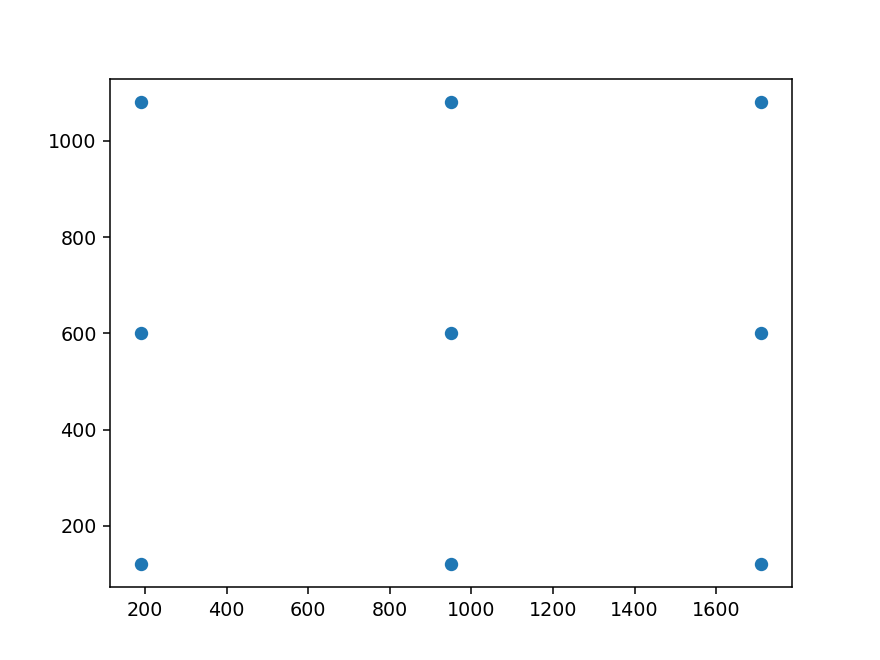

In [154]:
x, y = data.T
plt.scatter(x,y)
plt.show()